In [1]:
import rasterio

# Define file paths
april_img = r"D:\CECO\Image_2024_April\koraput\Kundra_April_2024.tif"
october_img = r"D:\CECO\Image 2024_October\Koraput\Kundra_oct_24.tif"
nov_img = r"D:\CECO\Image_2024_Nov\Kundra_Nov_2024.tif"

# Function to read a GeoTIFF file
def read_geotiff(file_path):
    try:
        with rasterio.open(file_path) as src:
            data = src.read()  # Read all bands
            meta = src.meta  # Metadata
            print(f"✅ Successfully read: {file_path}")
            print(f"📏 Image shape: {data.shape}")  # (bands, height, width)
            print(f"🌍 CRS: {meta['crs']}")  # Coordinate Reference System
            print(f"📌 Bounds: {src.bounds}")  # Geographical Extent
            return data, meta
    except Exception as e:
        print(f"❌ Error reading {file_path}: {e}")
        return None, None

# Read all three images
april_data, april_meta = read_geotiff(april_img)
october_data, october_meta = read_geotiff(october_img)
nov_data, nov_meta = read_geotiff(nov_img)


✅ Successfully read: D:\CECO\Image_2024_April\koraput\Kundra_April_2024.tif
📏 Image shape: (4, 11831, 11517)
🌍 CRS: EPSG:32644
📌 Bounds: BoundingBox(left=630556.8491, bottom=2076991.32, right=658197.6491, top=2105385.72)
✅ Successfully read: D:\CECO\Image 2024_October\Koraput\Kundra_oct_24.tif
📏 Image shape: (5, 11851, 11307)
🌍 CRS: EPSG:32645
📌 Bounds: BoundingBox(left=-1578.358081570197, bottom=2082719.9743155246, right=25558.441918429802, top=2111162.3743155245)
✅ Successfully read: D:\CECO\Image_2024_Nov\Kundra_Nov_2024.tif
📏 Image shape: (5, 11851, 11307)
🌍 CRS: EPSG:32645
📌 Bounds: BoundingBox(left=-1578.358081570197, bottom=2082719.9743155246, right=25558.441918429802, top=2111162.3743155245)


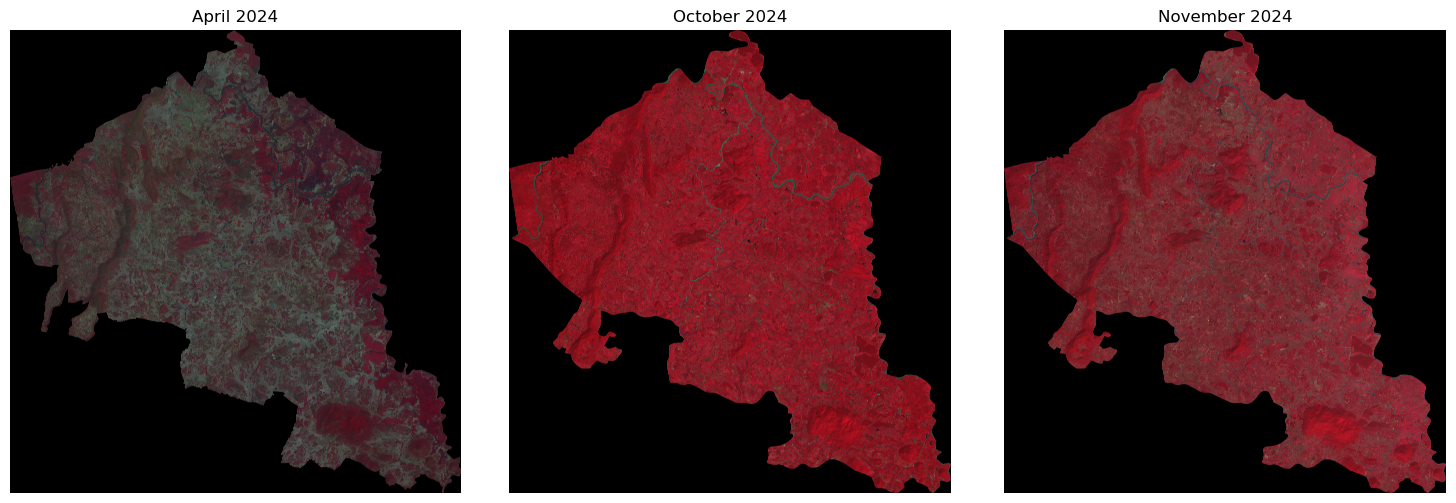

In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Function to read a GeoTIFF and extract RGB bands (Assuming R=Band 4, G=Band 3, B=Band 2)
def read_rgb(file_path):
    try:
        with rasterio.open(file_path) as src:
            # Read the bands (assuming standard satellite RGB band order: Red=4, Green=3, Blue=2)
            r = src.read(4).astype(np.float32)
            g = src.read(3).astype(np.float32)
            b = src.read(2).astype(np.float32)

            # Normalize values (scaling between 0 and 1 for visualization)
            r = (r - r.min()) / (r.max() - r.min())
            g = (g - g.min()) / (g.max() - g.min())
            b = (b - b.min()) / (b.max() - b.min())

            rgb_image = np.dstack((r, g, b))  # Stack as RGB image
            return rgb_image
    except Exception as e:
        print(f"❌ Error reading {file_path}: {e}")
        return None

# Read RGB images
april_rgb = read_rgb(april_img)
october_rgb = read_rgb(october_img)
nov_rgb = read_rgb(nov_img)

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Titles for subplots
titles = ["April 2024", "October 2024", "November 2024"]
images = [april_rgb, october_rgb, nov_rgb]

for ax, img, title in zip(axes, images, titles):
    if img is not None:
        ax.imshow(img)
        ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [3]:
import geopandas as gpd
import pandas as pd

path = r"D:\CECO\KUNDRA\Training_Poins_Kundra\Crops_random_points.shp"

# Load the training sample data
df = gpd.read_file(path)
df.head(1)

,rand_point,ID,PLOT_CODE1,MPLOT_NO,VILL_CODE,VILL_NAME,KHATA_NO,PLOT_NO,TAHASIL_CD,TAHASIL,...,PADDY,CROP_DL,SURV_DT,Year,Month,Year-Month,Crop_Group,CROP_NAME,CROP_CODE,geometry
0,0.0,505961,0813006-160,160,0813006,Giuriagura,NaN,NaN,0813,Kundra,...,NaN,Finger Millet,2024-09-15,2024,09,2024-09,Other Crops,Millets,1,POINT (640212.660 2088512.690)


In [4]:
df.shape

(292695, 24)

In [5]:
import rasterio

# Define file paths
april_img = r"D:\CECO\Image_2024_April\koraput\Kundra_April_2024.tif"
october_img = r"D:\CECO\Image 2024_October\Koraput\Kundra_oct_24.tif"
nov_img = r"D:\CECO\Image_2024_Nov\Kundra_Nov_2024.tif"



# Load the raster images and get CRS
with rasterio.open(april_img) as src_april:
    april_crs = src_april.crs

with rasterio.open(nov_img) as src_nov:
    nov_crs = src_nov.crs
shapefile_crs = df.crs
# Print CRS details
print(f"Shapefile CRS: {shapefile_crs}")
print(f"April Image CRS: {april_crs}")
print(f"November Image CRS: {nov_crs}")

Shapefile CRS: EPSG:32644
April Image CRS: EPSG:32644
November Image CRS: EPSG:32645


In [6]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Define the target CRS
target_crs = "EPSG:32644"

# Open the November image
nov_img_path = r"D:\CECO\Image_2024_Nov\Kundra_Nov_2024.tif"
nov_reprojected_path = r"D:\CECO\Image_2024_Nov\Kundra_Nov_2024_reprojected.tif"

with rasterio.open(nov_img_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, target_crs, src.width, src.height, *src.bounds
    )
    
    new_meta = src.meta.copy()
    new_meta.update({
        "crs": target_crs,
        "transform": transform,
        "width": width,
        "height": height
    })
    
    with rasterio.open(nov_reprojected_path, "w", **new_meta) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=target_crs,
                resampling=Resampling.nearest
            )

print("✅ November image reprojected to EPSG:32644")


✅ November image reprojected to EPSG:32644


In [7]:
import rasterio

# Define file paths
april_img = r"D:\CECO\Image_2024_April\koraput\Kundra_April_2024.tif"
october_img = r"D:\CECO\Image 2024_October\Koraput\Kundra_oct_24.tif"
nov_img =  r"D:\CECO\Image_2024_Nov\Kundra_Nov_2024_reprojected.tif"

# Load the raster images and get CRS
with rasterio.open(april_img) as src_april:
    april_crs = src_april.crs

with rasterio.open(nov_img) as src_nov:
    nov_crs = src_nov.crs
shapefile_crs = df.crs
# Print CRS details
print(f"Shapefile CRS: {shapefile_crs}")
print(f"April Image CRS: {april_crs}")
print(f"November Image CRS: {nov_crs}")

Shapefile CRS: EPSG:32644
April Image CRS: EPSG:32644
November Image CRS: EPSG:32644


In [8]:
df.shape

(292695, 24)

In [9]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 292695 entries, 0 to 292694
Data columns (total 24 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   rand_point  292695 non-null  float64 
 1   ID          292695 non-null  int64   
 2   PLOT_CODE1  292695 non-null  object  
 3   MPLOT_NO    292695 non-null  object  
 4   VILL_CODE   292695 non-null  object  
 5   VILL_NAME   292695 non-null  object  
 6   KHATA_NO    135826 non-null  object  
 7   PLOT_NO     135826 non-null  object  
 8   TAHASIL_CD  292695 non-null  object  
 9   TAHASIL     292695 non-null  object  
 10  TOT_AREA    135826 non-null  float64 
 11  RSGIS_DSN   135826 non-null  object  
 12  LU_CLASS    292695 non-null  object  
 13  LAND_USE    15999 non-null   object  
 14  PADDY       130424 non-null  object  
 15  CROP_DL     292695 non-null  object  
 16  SURV_DT     292695 non-null  object  
 17  Year        292695 non-null  object  
 18  Month       2926

In [1]:
import rasterio
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Point
from pyproj import Transformer

# Paths to input files
raster_paths = {
    "APR": r"D:\CECO\Image_2024_April\koraput\Kundra_April_2024.tif",
    "OCT": r"D:\CECO\Image 2024_October\Koraput\Kundra_oct_24.tif",
    "NOV": r"D:\CECO\Image_2024_Nov\Kundra_Nov_2024_reprojected.tif",
}

points_path = r"D:\CECO\KUNDRA\Training_Poins_Kundra\Crops_random_points.shp"

# Load point features
points = gpd.read_file(points_path)

# Select only necessary columns along with geometry
selected_columns = [
    "PLOT_CODE1", "VILL_CODE", "VILL_NAME", "TAHASIL", "LU_CLASS", "CROP_DL",
    "LAND_USE", "Crop_Group", "CROP_NAME", "CROP_CODE", "geometry"
]
points = points[selected_columns]

# Dictionary to store extracted features
all_features = {point_idx: {"X": row.geometry.x, "Y": row.geometry.y} for point_idx, row in points.iterrows()}

# Small epsilon value to prevent division by zero
eps = 1e-10  

# Clip reflectance values to avoid extreme cases
def safe_value(value, min_val=0, max_val=10000):
    return np.clip(value, min_val, max_val) / 10000.0  # Normalize if needed

# Function to process each raster
def extract_features(image_path, month_prefix):
    try:
        with rasterio.open(image_path) as dataset:
            image_array = dataset.read().astype(np.float32)
            band_count, height, width = image_array.shape

            points_transformed = points.to_crs(dataset.crs)

            for point_idx, row in points_transformed.iterrows():
                x, y = row.geometry.x, row.geometry.y  
                try:
                    row_idx, col_idx = dataset.index(x, y)
                    if 0 <= row_idx < height and 0 <= col_idx < width:
                        pixel_values = image_array[:, row_idx, col_idx]
                        pixel_values = np.nan_to_num(pixel_values, nan=0, posinf=0, neginf=0)
                        
                        blue = safe_value(pixel_values[0])
                        green = safe_value(pixel_values[1])
                        red = safe_value(pixel_values[2])
                        nir = safe_value(pixel_values[3])

                        ndvi = (nir - red) / np.maximum(nir + red, eps)
                        evi = 2.5 * ((nir - red) / np.maximum(nir + 6 * red - 7.5 * blue + 1, eps))  
                        savi = ((nir - red) / np.maximum(nir + red + 0.5, eps)) * 1.5
                        gci = (nir / np.maximum(green, eps)) - 1
                        arvi = (nir - 2 * red + blue) / np.maximum(nir + 2 * red + blue, eps)
                        msavi2 = (2 * nir + 1 - np.sqrt(np.maximum((2 * nir + 1) ** 2 - 8 * (nir - red), eps))) / 2
                        mtvi2 = (1.5 * (1.2 * (nir - green) - 2.5 * (red - green))) / \
                                np.sqrt(np.maximum((2 * nir + 1) ** 2 - (6 * nir - 5 * np.sqrt(np.maximum(red, eps))) - 0.5, eps))
                        tgi = -0.5 * (190 * (red - green) - 120 * (red - blue))

                        all_features[point_idx].update({
                            f"{month_prefix}_Band1": pixel_values[0],
                            f"{month_prefix}_Band2": pixel_values[1],
                            f"{month_prefix}_Band3": pixel_values[2],
                            f"{month_prefix}_Band4": pixel_values[3],
                            f"{month_prefix}_NDVI": ndvi,
                            f"{month_prefix}_EVI": evi,
                            f"{month_prefix}_SAVI": savi,
                            f"{month_prefix}_GCI": gci,
                            f"{month_prefix}_ARVI": arvi,
                            f"{month_prefix}_MSAVI2": msavi2,
                            f"{month_prefix}_MTVI2": mtvi2,
                            f"{month_prefix}_TGI": tgi,
                        })
                except Exception as e:
                    print(f"Error processing point ({x}, {y}) for {month_prefix}: {e}")
                    continue
    except Exception as e:
        print(f"Error reading raster {image_path}: {e}")

# Process all raster images
for month_prefix, raster_path in raster_paths.items():
    extract_features(raster_path, month_prefix)

# Convert features dictionary to DataFrame
df = pd.DataFrame.from_dict(all_features, orient="index")

# Merge extracted features back with the original points dataframe
df_final = points.merge(df, left_index=True, right_index=True, how="left")

# Define transformation from raster CRS to WGS84
transformer = Transformer.from_crs(points.crs, "EPSG:4326", always_xy=True)

def transform_coordinates(row):
    try:
        return transformer.transform(row["X"], row["Y"])
    except Exception as e:
        print(f"Error transforming coordinates ({row['X']}, {row['Y']}): {e}")
        return (None, None)

# Convert coordinates
df_final["Longitude"], df_final["Latitude"] = zip(*df_final.apply(transform_coordinates, axis=1))

# Drop rows with invalid coordinates
df_final = df_final.dropna(subset=["Longitude", "Latitude"])

df_final.shape

(292695, 51)

In [2]:
df_final.head()

,PLOT_CODE1,VILL_CODE,VILL_NAME,TAHASIL,LU_CLASS,CROP_DL,LAND_USE,Crop_Group,CROP_NAME,CROP_CODE,...,NOV_NDVI,NOV_EVI,NOV_SAVI,NOV_GCI,NOV_ARVI,NOV_MSAVI2,NOV_MTVI2,NOV_TGI,Longitude,Latitude
0,0813006-160,0813006,Giuriagura,Kundra,Agriculture,Finger Millet,NaN,Other Crops,Millets,1,...,0.551807,0.372089,0.353921,2.763636,0.345455,0.329817,0.274276,1.1275,82.331173,18.883937
1,0813006-160,0813006,Giuriagura,Kundra,Agriculture,Finger Millet,NaN,Other Crops,Millets,1,...,0.502521,0.320414,0.314002,2.619433,0.288604,0.287231,0.222991,0.7215,82.331607,18.883767
2,0813006-160,0813006,Giuriagura,Kundra,Agriculture,Finger Millet,NaN,Other Crops,Millets,1,...,0.487580,0.310401,0.305313,2.377693,0.272583,0.278522,0.217700,1.0005,82.331017,18.883645
3,0813006-160,0813006,Giuriagura,Kundra,Agriculture,Finger Millet,NaN,Other Crops,Millets,1,...,0.484707,0.311791,0.305771,2.462725,0.270101,0.279322,0.214346,0.7585,82.331252,18.883604
4,0813006-160,0813006,Giuriagura,Kundra,Agriculture,Finger Millet,NaN,Other Crops,Millets,1,...,0.492554,0.314857,0.307220,2.413882,0.279904,0.280272,0.219882,0.9065,82.331308,18.883692


In [3]:
df_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 292695 entries, 0 to 292694
Data columns (total 51 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   PLOT_CODE1  292695 non-null  object  
 1   VILL_CODE   292695 non-null  object  
 2   VILL_NAME   292695 non-null  object  
 3   TAHASIL     292695 non-null  object  
 4   LU_CLASS    292695 non-null  object  
 5   CROP_DL     292695 non-null  object  
 6   LAND_USE    15999 non-null   object  
 7   Crop_Group  292695 non-null  object  
 8   CROP_NAME   292695 non-null  object  
 9   CROP_CODE   292695 non-null  int64   
 10  geometry    292695 non-null  geometry
 11  X           292695 non-null  float64 
 12  Y           292695 non-null  float64 
 13  APR_Band1   292695 non-null  float32 
 14  APR_Band2   292695 non-null  float32 
 15  APR_Band3   292695 non-null  float32 
 16  APR_Band4   292695 non-null  float32 
 17  APR_NDVI    292695 non-null  float64 
 18  APR_EVI     2926

In [4]:
rename_mapping = {
    "APR_Band1": "APR_Blue",
    "APR_Band2": "APR_Green",
    "APR_Band3": "APR_Red",
    "APR_Band4": "APR_NIR",
    "OCT_Band1": "OCT_Blue",
    "OCT_Band2": "OCT_Green",
    "OCT_Band3": "OCT_Red",
    "OCT_Band4": "OCT_NIR",
    "NOV_Band1": "NOV_Blue",
    "NOV_Band2": "NOV_Green",
    "NOV_Band3": "NOV_Red",
    "NOV_Band4": "NOV_NIR",
}

df_final.rename(columns=rename_mapping, inplace=True)

df_final.info() # Check if renaming is correct


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 292695 entries, 0 to 292694
Data columns (total 51 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   PLOT_CODE1  292695 non-null  object  
 1   VILL_CODE   292695 non-null  object  
 2   VILL_NAME   292695 non-null  object  
 3   TAHASIL     292695 non-null  object  
 4   LU_CLASS    292695 non-null  object  
 5   CROP_DL     292695 non-null  object  
 6   LAND_USE    15999 non-null   object  
 7   Crop_Group  292695 non-null  object  
 8   CROP_NAME   292695 non-null  object  
 9   CROP_CODE   292695 non-null  int64   
 10  geometry    292695 non-null  geometry
 11  X           292695 non-null  float64 
 12  Y           292695 non-null  float64 
 13  APR_Blue    292695 non-null  float32 
 14  APR_Green   292695 non-null  float32 
 15  APR_Red     292695 non-null  float32 
 16  APR_NIR     292695 non-null  float32 
 17  APR_NDVI    292695 non-null  float64 
 18  APR_EVI     2926

In [5]:
df_final.drop(columns=["X", "Y"], inplace=True)

df_final.head()  # Verify that the columns are removed


,PLOT_CODE1,VILL_CODE,VILL_NAME,TAHASIL,LU_CLASS,CROP_DL,LAND_USE,Crop_Group,CROP_NAME,CROP_CODE,...,NOV_NDVI,NOV_EVI,NOV_SAVI,NOV_GCI,NOV_ARVI,NOV_MSAVI2,NOV_MTVI2,NOV_TGI,Longitude,Latitude
0,0813006-160,0813006,Giuriagura,Kundra,Agriculture,Finger Millet,NaN,Other Crops,Millets,1,...,0.551807,0.372089,0.353921,2.763636,0.345455,0.329817,0.274276,1.1275,82.331173,18.883937
1,0813006-160,0813006,Giuriagura,Kundra,Agriculture,Finger Millet,NaN,Other Crops,Millets,1,...,0.502521,0.320414,0.314002,2.619433,0.288604,0.287231,0.222991,0.7215,82.331607,18.883767
2,0813006-160,0813006,Giuriagura,Kundra,Agriculture,Finger Millet,NaN,Other Crops,Millets,1,...,0.487580,0.310401,0.305313,2.377693,0.272583,0.278522,0.217700,1.0005,82.331017,18.883645
3,0813006-160,0813006,Giuriagura,Kundra,Agriculture,Finger Millet,NaN,Other Crops,Millets,1,...,0.484707,0.311791,0.305771,2.462725,0.270101,0.279322,0.214346,0.7585,82.331252,18.883604
4,0813006-160,0813006,Giuriagura,Kundra,Agriculture,Finger Millet,NaN,Other Crops,Millets,1,...,0.492554,0.314857,0.307220,2.413882,0.279904,0.280272,0.219882,0.9065,82.331308,18.883692


In [6]:
df_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 292695 entries, 0 to 292694
Data columns (total 49 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   PLOT_CODE1  292695 non-null  object  
 1   VILL_CODE   292695 non-null  object  
 2   VILL_NAME   292695 non-null  object  
 3   TAHASIL     292695 non-null  object  
 4   LU_CLASS    292695 non-null  object  
 5   CROP_DL     292695 non-null  object  
 6   LAND_USE    15999 non-null   object  
 7   Crop_Group  292695 non-null  object  
 8   CROP_NAME   292695 non-null  object  
 9   CROP_CODE   292695 non-null  int64   
 10  geometry    292695 non-null  geometry
 11  APR_Blue    292695 non-null  float32 
 12  APR_Green   292695 non-null  float32 
 13  APR_Red     292695 non-null  float32 
 14  APR_NIR     292695 non-null  float32 
 15  APR_NDVI    292695 non-null  float64 
 16  APR_EVI     292695 non-null  float64 
 17  APR_SAVI    292695 non-null  float64 
 18  APR_GCI     2926

In [7]:
# Save the updated DataFrame
Points_path = r"D:\CECO\KUNDRA"
output_csv = f"{Points_path}\\Sampledata_indices_Kundra_3months.csv"
df_final.to_csv(output_csv, index=False)

print(f"Feature extraction completed! Data saved as '{output_csv}' with Lat/Lon for 3 images.")


Feature extraction completed! Data saved as 'D:\CECO\KUNDRA\Sampledata_indices_Kundra_3months.csv' with Lat/Lon for 3 images.


In [10]:
# Save updated DataFrame
output_shapefile = r"D:\CECO\KUNDRA\Sample_Data_Indices_Kundra_3months\Sampledata_indices_Kundra_3months.shp"
df_final.to_file(output_shapefile)


print("✅ Updated data saved successfully!")


✅ Updated data saved successfully!


In [ ]:
# Save updated DataFrame
output_shapefile = r"D:\CECO\Boipariguda\Training_points\Training_sample_points_1.2L\Training_sample_points_updated.shp"
df.to_file(output_shapefile)

output_csv = r"D:\CECO\Boipariguda\Training_points\Training_sample_points_1.2L\Training_sample_points_updated.csv"
df.to_csv(output_csv, index=False)

print("✅ Updated data saved successfully!")
